In [31]:
import numpy             as np
import matplotlib.pyplot as plt

from matplotlib          import rcParams, rc
# Change the matplotlib default parameters
# rcParams.update({'font.size':   12})
rcParams.update({'figure.dpi': 200})
# rc('font', family='serif')
# rc('text', usetex=True)

from astropy import units as units

from src.odes           import ODE
from src.rates          import initialise_abs, calculate_rates, read_specs_file
from src.input          import setinput, getcst, density

from scipy.integrate    import solve_ivp
from astropy            import constants

specs, parnt, consv = read_specs_file('C')

specs_dict = dict()
for i in range(len(specs)):
    specs_dict[specs[i]] = i

In [5]:


## input values physics
def setinput(Mdot, vexp, r, T, δ, Av, chemtype):
    '''
    Set input values of the model.

    INPUT:
        - ρ  = density       [g/cm^3]
            via mass-loss rate (Mdot [Msol/yr]) & expansion velocity (vexp [km/s])
        - T  = temperature   [K]
        - δ  = outwards dilution of radiation field     == RAD
        - Av = outward dus extinction
        - chemtype = type of chemistry: 'C' or 'O'
    '''

    ## input physics
    ρ = density(Mdot, vexp, r)

    print('Input:')
    print('------')
    print('ρ  =','{:.2E}'.format(ρ))
    print('T  =',T)
    print('δ  =',δ)
    print('Av =',Av)
    print('')
    print('Chem type =', chemtype)

    return ρ, T, δ, Av, chemtype

def solve(ρ, T, δ, Av, chemtype, Δt):

    ## calculate H accretion on dust
    Haccr = stckH *np.pi*(rGr**2.0)*ρ*nGr*(8.0*kB*T/(np.pi*mH))**0.5

    ## set initial conditions
    n, nconsv_tot, specs = initialise_abs(chemtype)     # nconsv_tot = TOTAL in fortran code
    timesteps = 1

    ndot        = np.zeros(len(n))
    nconsv      = np.zeros(len(nconsv_tot))
    t           = np.zeros(timesteps)

    k = calculate_rates(T, δ, Av)

    Δt = Δt*yr_to_sec  ## in sec


    print(' >> Solving ODE ...')
    ## solve ODE
    solution = solve_ivp(
        fun          = ODE,
        t_span       = [0.0, Δt],
        y0           = n,
        method       = 'BDF',   ## zoals DVODE
        args         = (ndot, nconsv, nconsv_tot,k, ρ, Haccr),
        dense_output = False    ## if True: returns interpolation function
        )

    assert solution['status'] == 0

    ys = solution['y']
    ts = solution['t']

    print(solution['message'])

    return ts, ys

def plot(ts, ys):
    fig = plt.figure(figsize=(8,6))

    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    axs = [ax1,ax2]

    for i in range(ys.shape[0]):
        ax1.plot(ts, ys[i])
        ax2.plot(ts, -ys[i])

    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')

        # ax.set_ylim((1.0e-40, 1.0e+0))

    ax.set_xlabel('time [s]')
    ax1.set_ylabel('abundance')
    ax2.set_ylabel('negative abundance')

    plt.show()

    return

def search_negs(ys, elwise = False, el = None):
    idx_neg = list()

    if elwise == False:
        for i in range(ys.shape[0]):
            if np.any(ys[i] < 0):
                idx_neg.append(i)

    if elwise == True:
        for i in range(ys.shape[0]):
            if np.any(ys[i][el] < 0):
                idx_neg.append(i)


    specs_neg = list()

    for idx in idx_neg:
        specs_neg.append(specs[idx])

    return idx_neg, specs_neg

### Test simulations

In [3]:
## constants
kB, mH, rGr, nGr, stckH, AUV_AV = getcst()
yr_to_sec = units.year.to('s')         ## year in seconds

In [23]:
## Sim 1
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1., 1., 'C')
ts1, ys1 = solve(ρ, T, δ, Av, chemtype, 1.e1)

Input:
------
ρ  = 2.25E+04
T  = 2500.0
δ  = 1.0
Av = 1.0

Chem type = C
 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [24]:
## Sim 2
ρ, T, δ, Av, chemtype = setinput(1.e-6, 15., 1.e15, 2500., 1., 1., 'C')
ts2, ys2 = solve(ρ, T, δ, Av, chemtype, 1.e1)

Input:
------
ρ  = 7.51E+05
T  = 2500.0
δ  = 1.0
Av = 1.0

Chem type = C
 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [25]:
## Sim 3
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1., 1., 'O')
ts3, ys3 = solve(ρ, T, δ, Av, chemtype, 1.e1)

Input:
------
ρ  = 2.25E+04
T  = 2500.0
δ  = 1.0
Av = 1.0

Chem type = O
 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [26]:
## Sim 4
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1.e-5, 0.5, 'C')
ts4, ys4 = solve(ρ, T, δ, Av, chemtype, 1.e1)

Input:
------
ρ  = 2.25E+04
T  = 2500.0
δ  = 1e-05
Av = 0.5

Chem type = C
 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


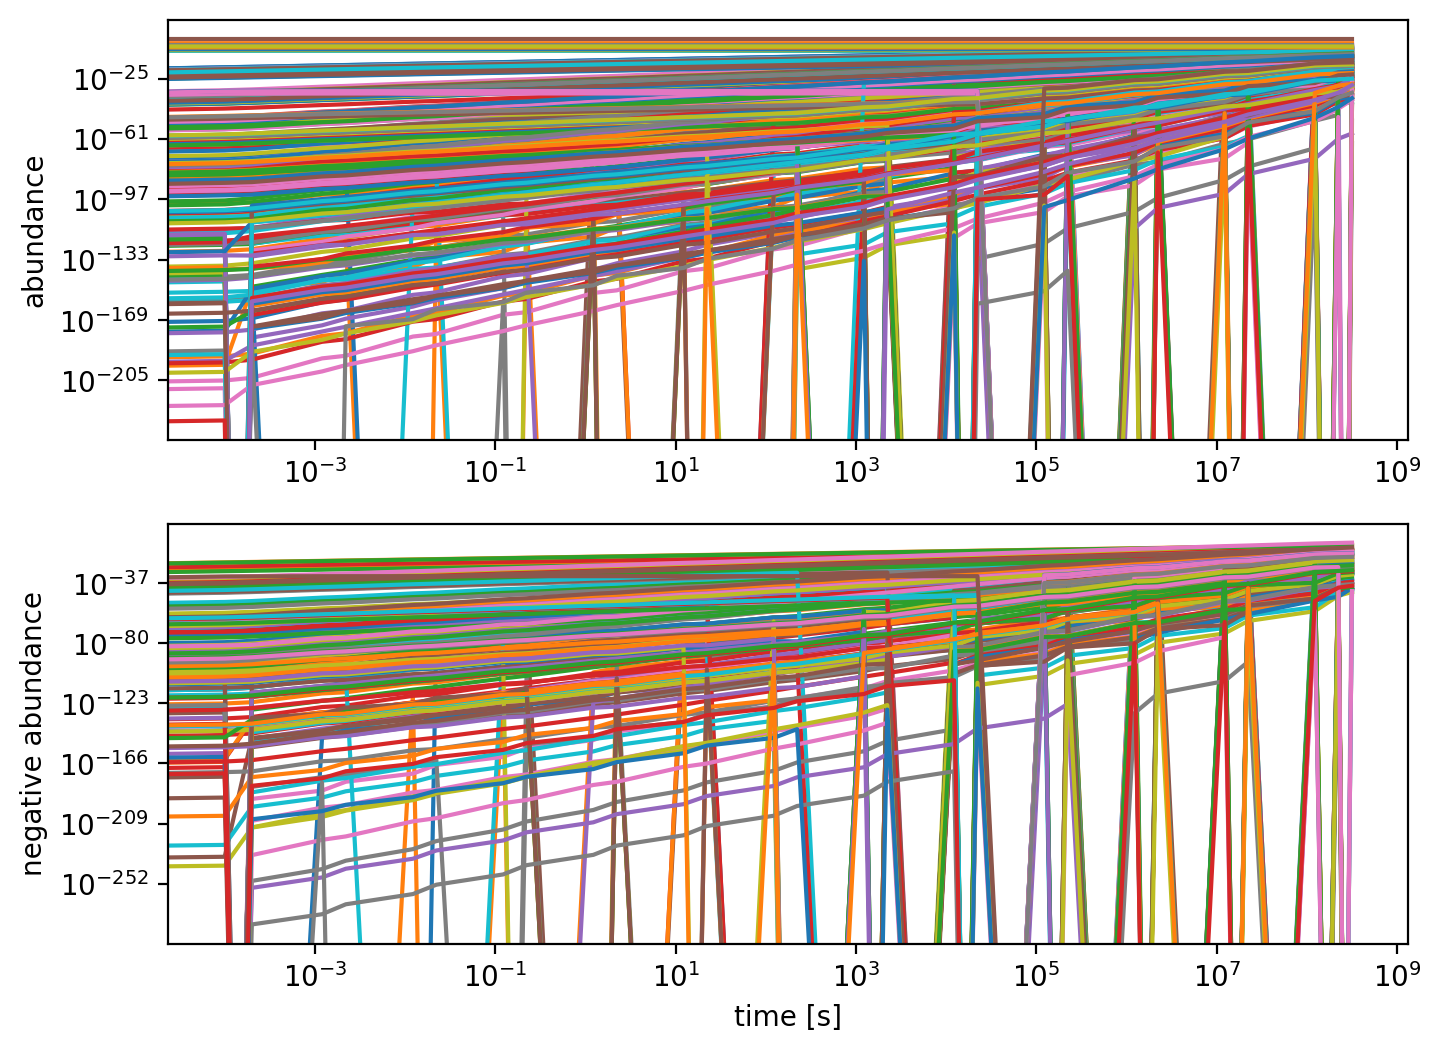

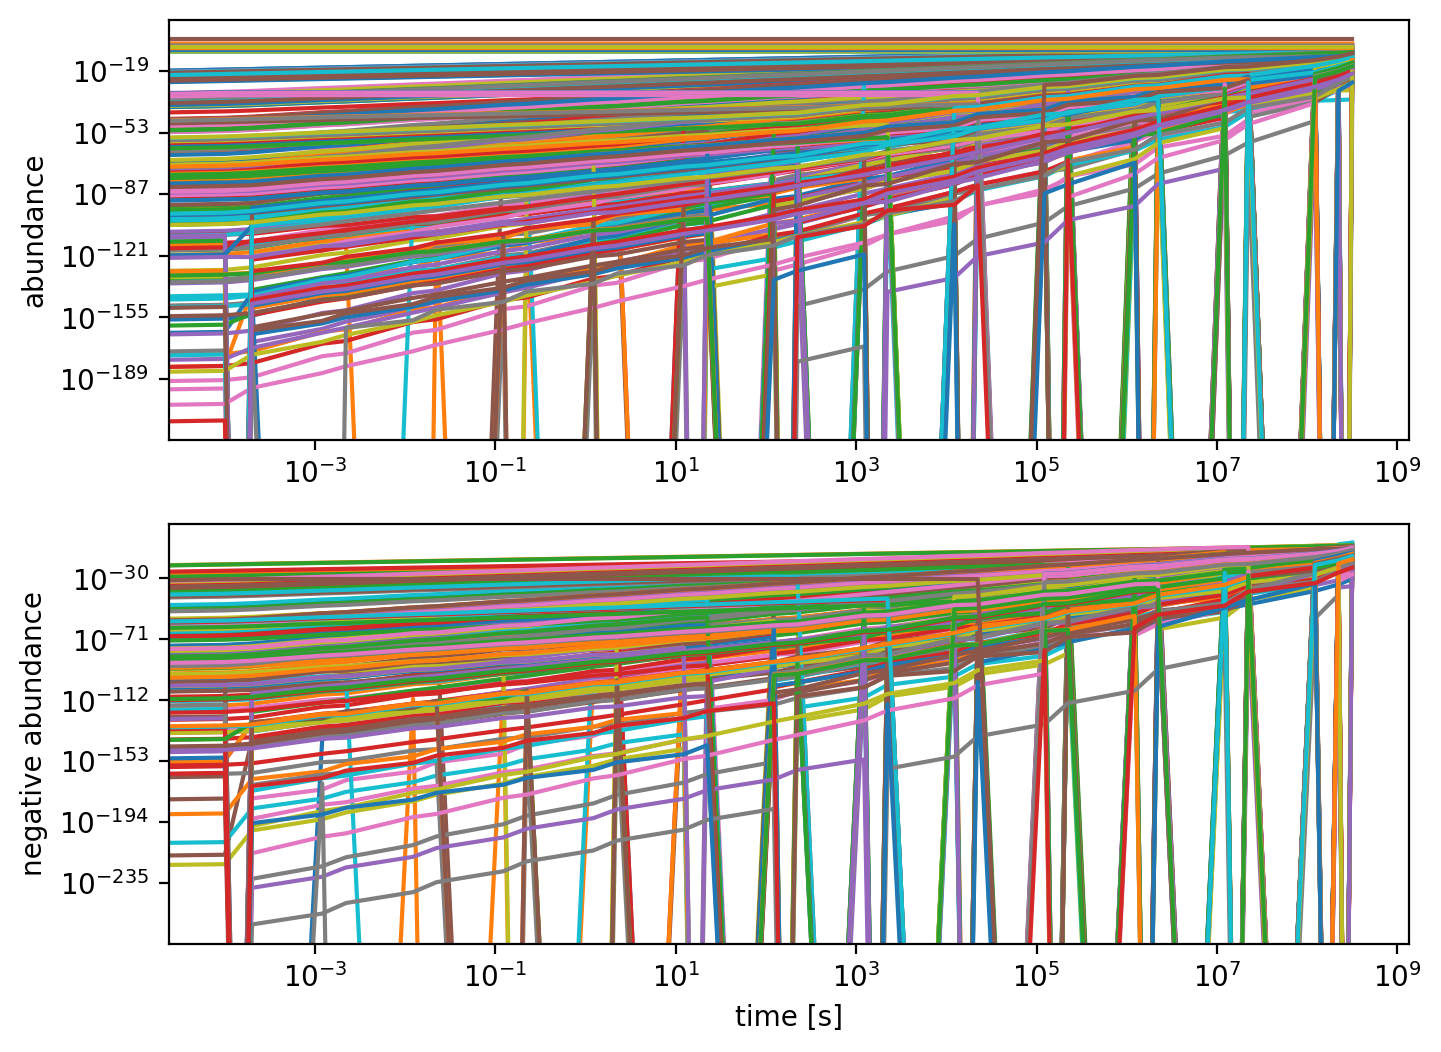

In [10]:
plot(ts1, ys1)
plot(ts2,ys2)

### Search for negatives

In [44]:
## ys1 - sim 1

idx_neg, specs_neg = search_negs(ys1)
print(len(idx_neg))
print(idx_neg)
print(specs_neg)

113
[1, 2, 3, 7, 11, 20, 21, 29, 42, 51, 57, 82, 83, 85, 91, 92, 98, 101, 108, 109, 113, 114, 116, 117, 118, 120, 121, 122, 127, 128, 136, 161, 164, 165, 167, 176, 178, 179, 182, 186, 188, 189, 192, 194, 196, 201, 202, 208, 211, 212, 215, 216, 217, 224, 227, 234, 235, 240, 243, 248, 252, 255, 260, 262, 263, 275, 276, 280, 282, 287, 294, 296, 312, 318, 319, 320, 321, 323, 324, 329, 333, 339, 353, 354, 356, 365, 367, 368, 369, 373, 379, 391, 392, 394, 396, 397, 399, 400, 409, 416, 418, 420, 424, 427, 428, 436, 437, 439, 446, 448, 452, 456, 465]
['H+', 'H-', 'H2+', 'HeH+', 'CH-', 'NH+', 'CH3+', 'OH-', 'HF+', 'C2H-', 'CN-', 'HOC+', 'N2H+', 'SiH2', 'CH3CH3', 'SiH2+', 'SiH3+', 'C2H7+', 'CH3OH', 'SiH4+', 'PH+', 'CH3OH+', 'CH3OH2+', 'O2H', 'PH2+', 'HS+', 'PH2', 'O2H+', 'PH3+', 'H3S+', 'H2Cl+', 'HCSi+', 'CH3CN', 'C3H6+', 'CH3CNH+', 'OCN+', 'CP+', 'HNCO', 'HONC', 'C3H7+', 'HNSi+', 'HOCN', 'HOCN+', 'HONC+', 'HCNOH+', 'H2OCN+', 'HNCOH+', 'H2CNO+', 'H2NCO+', 'HCP+', 'HCS+', 'SiOH+', 'PN+', 'H2SiO',

In [45]:
idx_neg, specs_neg = search_negs(ys1, elwise = True, el=1)
print(len(idx_neg))
for i in range(len(idx_neg)):
    print(idx_neg[i], specs_neg[i])

72
1 H+
2 H-
3 H2+
7 HeH+
11 CH-
29 OH-
42 HF+
51 C2H-
57 CN-
82 HOC+
83 N2H+
85 SiH2
91 CH3CH3
92 SiH2+
98 SiH3+
101 C2H7+
113 PH+
117 O2H
118 PH2+
122 O2H+
128 H3S+
136 H2Cl+
161 HCSi+
165 C3H6+
178 CP+
186 C3H7+
188 HNSi+
189 HOCN
192 HOCN+
202 HNCOH+
211 H2NCO+
212 HCP+
215 HCS+
216 SiOH+
217 PN+
227 CH2PH
234 PCH3+
248 PCH4+
255 HPO
260 PNH3+
263 H2PO+
282 SiC2+
287 C3O+
294 NCCNH+
296 CH2CHCNH+
320 PC2H3+
323 PC2H4+
329 SiS+
353 SiC3
354 H2C4N+
356 HS2
365 H2S2+
367 H2S2
368 H3S2+
373 C3S+
379 C6H+
391 HC5NH+
392 SiC4
394 SiC4H+
396 C6H6
397 C6H6+
399 C6H7+
409 C7H+
416 CH3C5N
418 CH3C5NH+
424 C8H-
427 C7N+
428 C8H2+
439 C9H+
452 C10H+
456 C9N+
465 C11+


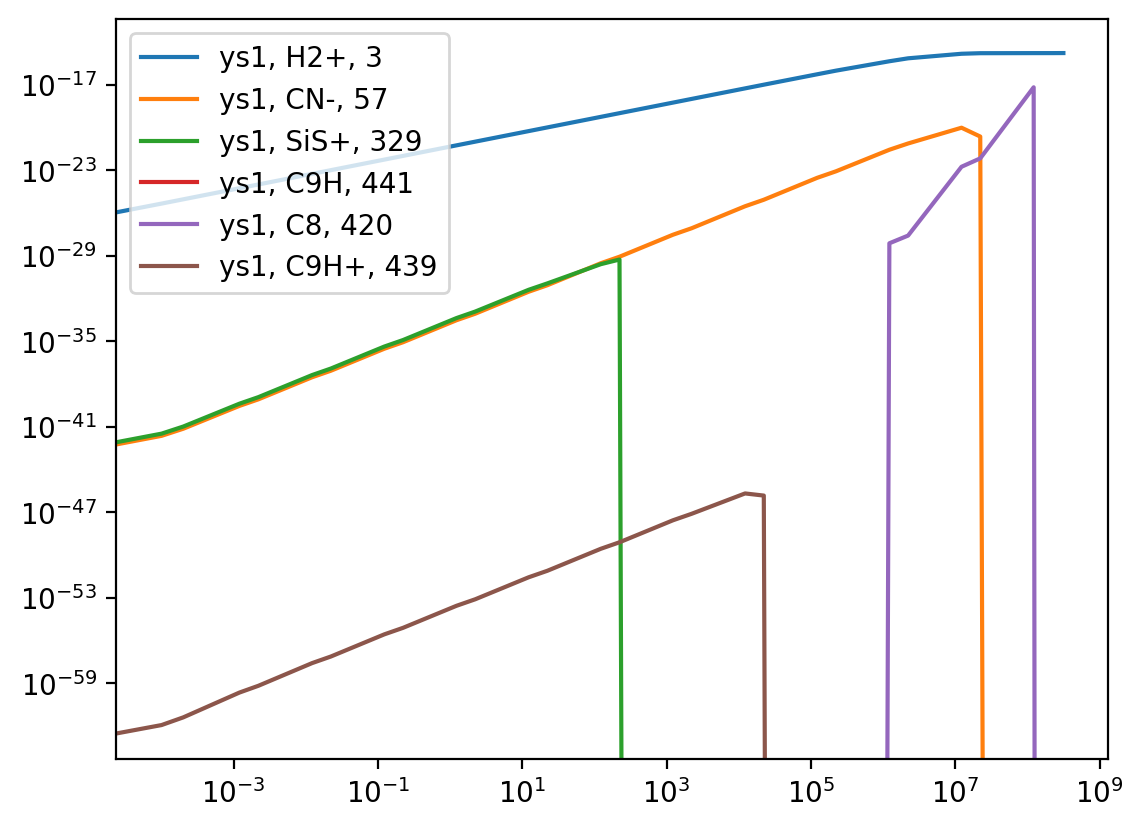

In [43]:
nbs = [57, 26, 55, 30, 9, 88, 3, 60, 18, 450, 454, 47, 134, 138, 254, 262,329, 341, 376, 381, 408, 409, 420, 425, 439, 441, 60]

nbs = [3, 57, 329, 441, 420, 439]

for nb in nbs:
    plt.loglog(ts1, -ys1[nb], label = "ys1, "+specs[nb]+', '+str(nb))
    # plt.loglog(ts2, -ys2[nb], label = "ys2, "+specs[nb])
    # plt.loglog(ts3, -ys3[nb], label = "ys3, "+specs[nb])
    # plt.loglog(ts4, -ys4[nb], label = "ys4, "+specs[nb])
plt.legend(loc = 'upper left')
plt.show()

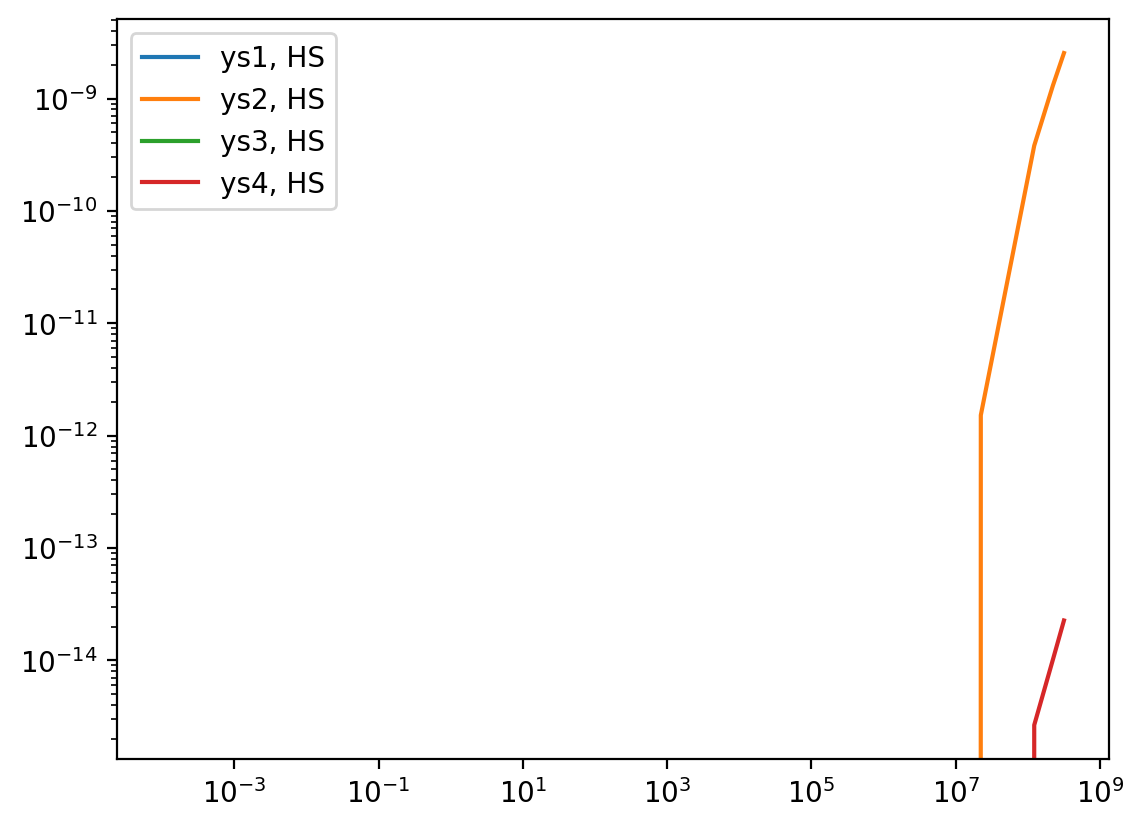

In [32]:
molecs = ['HS']

for molec in molecs:
    nb = specs_dict[molec]
    plt.loglog(ts1, -ys1[nb], label = "ys1, "+specs[nb])
    plt.loglog(ts2, -ys2[nb], label = "ys2, "+specs[nb])
    plt.loglog(ts3, -ys3[nb], label = "ys3, "+specs[nb])
    plt.loglog(ts4, -ys4[nb], label = "ys4, "+specs[nb])
plt.legend(loc = 'upper left')
plt.show()

In [54]:
ions = list()
for spec in specs:
    if spec[-1] == '+' or spec[-1] == '-':
        ions.append(spec)


In [55]:
len(ions)

296